In [ ]:
import json
with open('cache.json', 'r') as f:
    data = json.load(f)
    # unique items
    print(len(set(data)))
    del data

In [19]:
import numpy as np
import pandas as pd
df = pd.read_csv('13k.csv')

In [85]:
df.columns
"""
 Index(['eventId', 'eventUid', 'eventName', 'eventCategory', 'eventLocation',
       'clubId', 'clubLogin', 'clubName', 'eventAttendees', 'eventPicture',
       'eventPriceRange', 'eventButtonLabel', 'eventBadges',
       'totalTicketsSoldValue', 'checkbox_id', 'eventUrl', 'displayType',
       'registered', 'waiting_list', 'eventTags', 'coHostId',
       'custom_time_instruction', 'checkin', 'registrationStatus',
       'printTicket', 'eventTimezone', 'ariaEventDetails',
       'ariaEventDetailsWithLocation', 'parentEventIds', 'all_results_hidden',
       'hybrid', 'dayofweek', 'month', 'day', 'year', 'time', 'eventDates'],
      dtype='object')
"""

"\n Index(['eventId', 'eventUid', 'eventName', 'eventCategory', 'eventLocation',\n       'clubId', 'clubLogin', 'clubName', 'eventAttendees', 'eventPicture',\n       'eventPriceRange', 'eventButtonLabel', 'eventBadges',\n       'totalTicketsSoldValue', 'checkbox_id', 'eventUrl', 'displayType',\n       'registered', 'waiting_list', 'eventTags', 'coHostId',\n       'custom_time_instruction', 'checkin', 'registrationStatus',\n       'printTicket', 'eventTimezone', 'ariaEventDetails',\n       'ariaEventDetailsWithLocation', 'parentEventIds', 'all_results_hidden',\n       'hybrid', 'dayofweek', 'month', 'day', 'year', 'time', 'eventDates'],\n      dtype='object')\n"

             clubId  eventAttendees   checkbox_id  waiting_list     checkin  \
count  1.216000e+04    12160.000000  1.216000e+04           0.0  240.000000   
mean   2.543033e+08       36.829030  3.002879e+08           NaN    0.437500   
std    4.981847e+07       95.188386  5.748013e+04           NaN    0.497115   
min    2.000000e+08        0.000000  3.000761e+08           NaN    0.000000   
25%    2.000006e+08        2.000000  3.002541e+08           NaN    0.000000   
50%    3.000019e+08       10.000000  3.002994e+08           NaN    0.000000   
75%    3.000029e+08       35.000000  3.003243e+08           NaN    1.000000   
max    3.000216e+08     2277.000000  3.003681e+08           NaN    1.000000   

                day          year  
count  12160.000000  12160.000000  
mean      16.593092   2023.152796  
std        8.446085      0.359806  
min        1.000000   2023.000000  
25%       10.000000   2023.000000  
50%       17.000000   2023.000000  
75%       24.000000   2023.000000  


array([[<AxesSubplot: title={'center': 'clubId'}>,
        <AxesSubplot: title={'center': 'eventAttendees'}>,
        <AxesSubplot: title={'center': 'checkbox_id'}>],
       [<AxesSubplot: title={'center': 'waiting_list'}>,
        <AxesSubplot: title={'center': 'checkin'}>,
        <AxesSubplot: title={'center': 'day'}>],
       [<AxesSubplot: title={'center': 'year'}>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

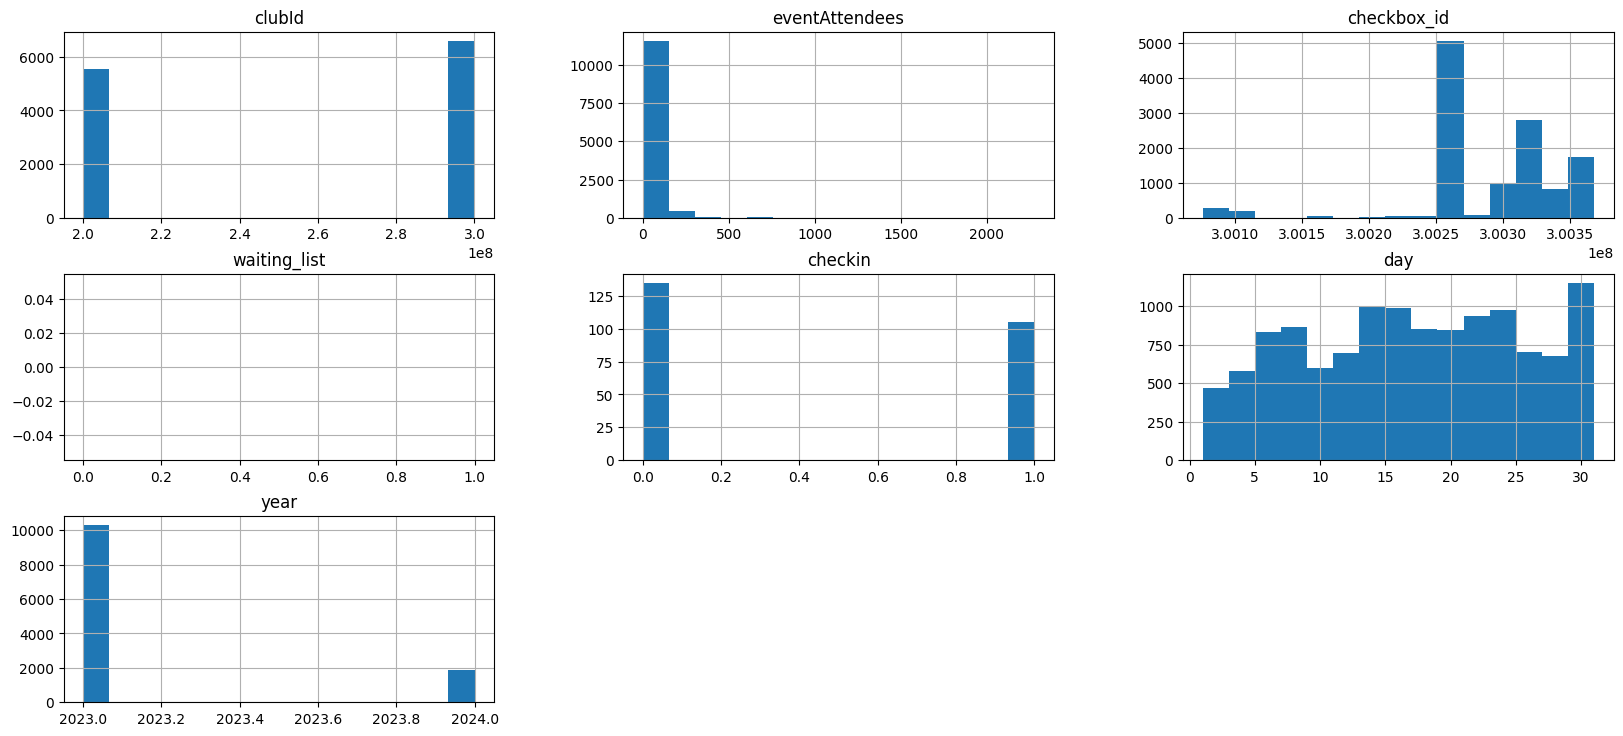

In [21]:
# Display the first few rows of the DataFrame

# Get the summary statistics of the DataFrame
print(df.describe())

# Check for missing values
# Analyze the distribution of categorical variables
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())
    print("\n")

# Analyze the distribution of numerical variables
df.select_dtypes(include=[np.number]).hist(bins=15, figsize=(20, 15), layout=(5, 3))

In [22]:
# hmm any duplicated rows?
df.duplicated().sum()

10291

In [23]:
df = df.drop_duplicates()

In [81]:
df.sample(1)

1555   NaN
Name: waiting_list, dtype: float64

In [83]:
df['waiting_list'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: waiting_list, dtype: float64

array([0.55, 0.47, 0.55, 0.55, 0.34])

In [110]:
def transform_data(df):
    # Fill missing values
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column].fillna('Unknown', inplace=True)
        else:
            df[column].fillna(df[column].mean(), inplace=True)

    # strip all strings
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.strip()

    # Extract features
    df['hour'] = df['time'].str.split('–').str[0].str.strip().str.lower()
    print(df['hour'])
    # some are 00:00 AM, 00:00 PM, 12:00 AM, 12:00 PM
    # some are 9 AM, 9 PM
    # some are 9:30 AM, 9:30 PM
    # correctly parse:
    # manual extraction of AM/PM and times
    from datetime import datetime
    def manual(str):
        # if no num in str, return 0
        if not any(i.isdigit() for i in str):
            return 0
        base = datetime.strptime('00:00', '%H:%M')
        am = 'am' in str
        str = str.replace(' AM', '').replace(' PM', '').replace('am', '').replace('pm', '')
        str = str.strip()
        if ':' in str:
            time = datetime.strptime(str, '%I:%M')
        else:
            time = datetime.strptime(str, '%I')
        if am:
            return (time - base).seconds / 3600
        else:
            return (time - base).seconds / 3600 + 12
    df['hour'] = df['hour'].apply(manual)
    # Extract the date
        
    # Drop unnecessary columns
    df.drop(['eventPicture', 'eventUrl'], axis=1, inplace=True)

    # drop rows with eventUid = separator
    df = df[df['eventUid'] != 'separator']

    def extract_num(str):
        if not any(i.isdigit() for i in str):
            return 0
        return int(''.join([i for i in str if i.isdigit()]))
    df['spots_left'] = df['registrationStatus'].apply(extract_num)

    checkin_dist_mean = 0.44
    checkin_min, checkin_max = 0, 1
    distribution = np.random.triangular(checkin_min, checkin_dist_mean, checkin_max, len(df))
    distribution = np.round(distribution, 2)
    df['checkin'] = distribution
    
    
    df['success'] = df['checkin'] * df['eventAttendees'] / (df['eventAttendees'] + df['spots_left'])
    

    return df
td = transform_data(df.copy())
td.head()

0            8 pm
1            7 pm
2        10:30 am
3        10:30 am
4         8:45 am
           ...   
13164     3:30 pm
13165        3 pm
13166        3 pm
13167       12 pm
13168       12 pm
Name: hour, Length: 2878, dtype: object


,eventId,eventUid,eventName,eventCategory,eventLocation,clubId,clubLogin,clubName,eventAttendees,eventPriceRange,...,hybrid,dayofweek,month,day,year,time,eventDates,hour,spots_left,success
0,300368144,a564e3f3f56cb3cc5f952a17116f0353,Tickets for contemporary dance show 'TRAJAL HA...,Off Campus,Centro de Cultura Contemporánea Conde Duque (c...,300002145.00,humanities,IE School of Humanities,12.00,FREE,...,Unknown,Sat,Feb,24.00,2024.00,8 PM – 10 PM,Unknown,20.00,0,0.83
1,300367873,9de91104ee5fb18e4f440bcd9495b02b,Weekly Running Practices,Hybrid,Private Location (register to display),300002813.00,ierunners,IE Runners Club MIX,0.00,FREE,...,Unknown,Sat,Feb,24.00,2024.00,7 PM – 11:30 AM,Unknown,19.00,0,NaN
2,300316787,2a9807915a7dabbc3f65b588649de81c,Saturday Weekly Running Practices,Off Campus,Private Location (register to display),300002813.00,ierunners,IE Runners Club MIX,27.00,FREE,...,Unknown,Sat,Feb,24.00,2024.00,10:30 AM – 11:30 AM,Unknown,10.50,0,0.47
3,300368022,7577703fb9dd0624e98b91d46d28cac6,THEATRE REHEARSAL - Act 2 Scene 2,On Campus,"IE TOWER, Piano Lounge",200000032.00,ietheatre,IE Theatre Production,7.00,FREE,...,Unknown,Sat,Feb,24.00,2024.00,10:30 AM – 2 PM,Unknown,10.50,0,0.34
4,300368019,fca36e0ded3f2a8e493b3576ad802587,Hike to Rascafría and Guided Tour of the Monas...,Off Campus,TBD,300002116.00,ieaexp,IExplore,18.00,€12,...,Unknown,Sat,Feb,24.00,2024.00,8:45 AM – 6:30 PM,Unknown,8.75,0,0.57


In [26]:
event_categories_list = [
    "Academic and Research",
    "Professional Development and Career",
    "Arts, Culture, and Humanities",
    "Sports and Wellness",
    "Community and Networking",
    "Entrepreneurship and Business Development",
    "Diversity and Inclusion",
    "Education and Training",
    "Global Affairs and Sustainability",
    "Recreational and Leisure Activities",
    "Technology and Digital Transformation",
    "Legal and Law-Related"
]
import torch
def str_to_list(str):
    i = str
    split_inds = [0]
    for ch in range(len(i)):
        if i[ch].isupper() and i[ch-1].islower():
            split_inds.append(ch)
            break
    split_inds.append(len(i))
    return [i[split_inds[j]:split_inds[j+1]] for j in range(len(split_inds)-1)]
def tags_dict(df):
    from transformers import pipeline
    classifier = pipeline("zero-shot-classification",
                          model="facebook/bart-large-mnli",
                          device=(0 if torch.cuda.is_available() else -1)
                          )
 
    tags = set()
    # show progress
    from tqdm import tqdm
    for i in tqdm(df['eventTags']):
        if i != 'Unknown':
            clas = classifier(i, event_categories_list)
            clas = clas['labels'][0]
            # cache the df
            df.to_csv('_cache_transformed_data.csv', index=False)
            df['eventClass'] = clas
    
    return df
redo = False
if redo:
    td = tags_dict(td)
else:
#    tdtmp = pd.read_csv('classified_events.csv')
 #   td['eventClass'] = tdtmp['eventClass']
    pass

In [27]:
# all event details ariaEventDetailsWithLocation - save to txt
with open('event_details.txt', 'w') as f:
    for i in td['ariaEventDetailsWithLocation']:
        f.write(i + '\n')

In [28]:
# save df as fully transformed
td.to_csv('transformed_data.csv', index=False)
td = pd.read_csv('transformed_data.csv')
td.head()

,eventId,eventUid,eventName,eventCategory,eventLocation,clubId,clubLogin,clubName,eventAttendees,eventPriceRange,...,parentEventIds,all_results_hidden,hybrid,dayofweek,month,day,year,time,eventDates,hour
0,300368144,a564e3f3f56cb3cc5f952a17116f0353,Tickets for contemporary dance show 'TRAJAL HA...,Off Campus,Centro de Cultura Contemporánea Conde Duque (c...,300002145.0,humanities,IE School of Humanities,12.0,FREE,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,8 PM – 10 PM,Unknown,20.00
1,300367873,9de91104ee5fb18e4f440bcd9495b02b,Weekly Running Practices,Hybrid,Private Location (register to display),300002813.0,ierunners,IE Runners Club MIX,0.0,FREE,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,7 PM – 11:30 AM,Unknown,19.00
2,300316787,2a9807915a7dabbc3f65b588649de81c,Saturday Weekly Running Practices,Off Campus,Private Location (register to display),300002813.0,ierunners,IE Runners Club MIX,27.0,FREE,...,Weekly Running Practices,NaN,Unknown,Sat,Feb,24.0,2024.0,10:30 AM – 11:30 AM,Unknown,10.50
3,300368022,7577703fb9dd0624e98b91d46d28cac6,THEATRE REHEARSAL - Act 2 Scene 2,On Campus,"IE TOWER, Piano Lounge",200000032.0,ietheatre,IE Theatre Production,7.0,FREE,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,10:30 AM – 2 PM,Unknown,10.50
4,300368019,fca36e0ded3f2a8e493b3576ad802587,Hike to Rascafría and Guided Tour of the Monas...,Off Campus,TBD,300002116.0,ieaexp,IExplore,18.0,€12,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,8:45 AM – 6:30 PM,Unknown,8.75


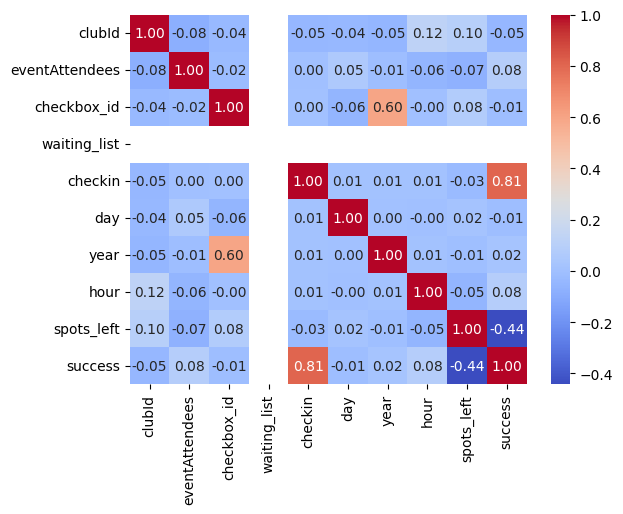

In [111]:
# corr between numerical variables
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(td.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

<AxesSubplot: xlabel='registered', ylabel='Count'>

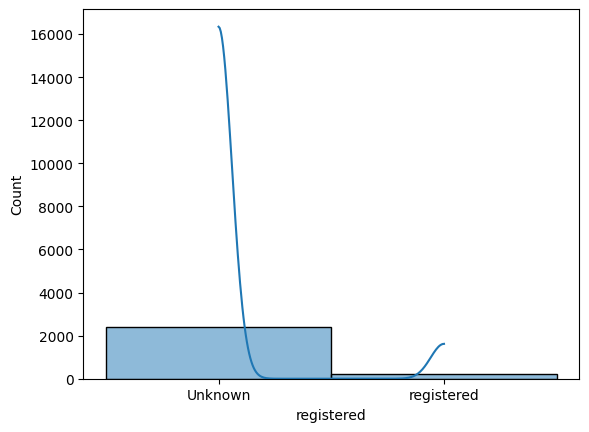

In [100]:
sns.histplot(td['registered'], kde=True)

<AxesSubplot: xlabel='success', ylabel='Count'>

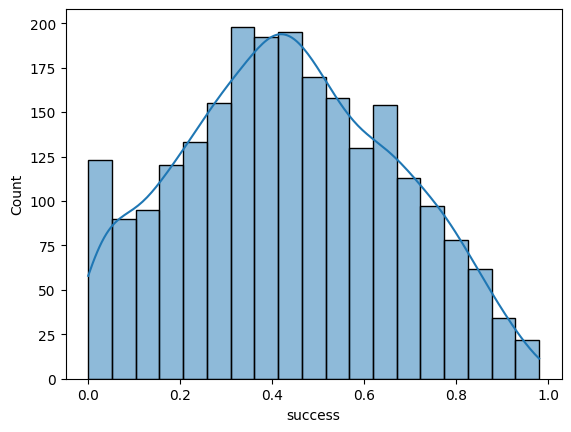

In [112]:
sns.histplot(td['success'], kde=True)

<AxesSubplot: xlabel='checkin', ylabel='Count'>

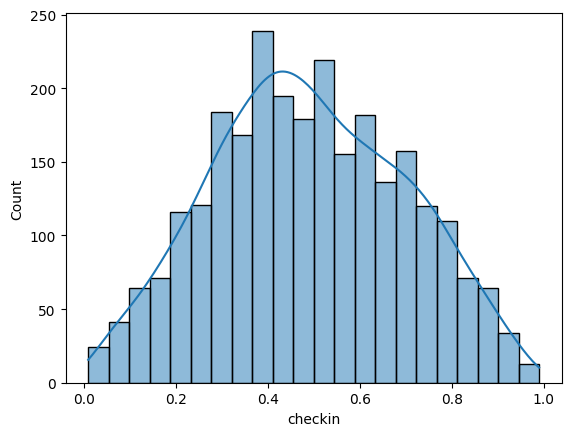

In [113]:
sns.histplot(td['checkin'], kde=True)

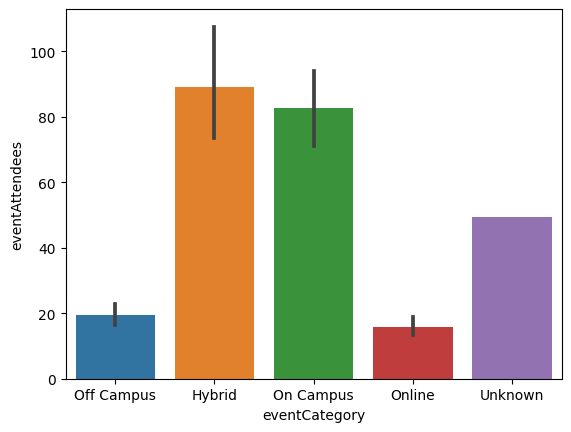

In [114]:
# eventCategory-eventAttendees
sns.barplot(x='eventCategory', y='eventAttendees', data=td)
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'TalentCareers'),
  Text(1, 0, 'iesportswellbeing'),
  Text(2, 0, 'iecampuslife'),
  Text(3, 0, 'ieroboticsai'),
  Text(4, 0, 'iefoundation'),
  Text(5, 0, 'tcalumni'),
  Text(6, 0, 'ieeic'),
  Text(7, 0, 'ielanguagecenter'),
  Text(8, 0, 'iefootball'),
  Text(9, 0, 'GPAUndergradstudents')])

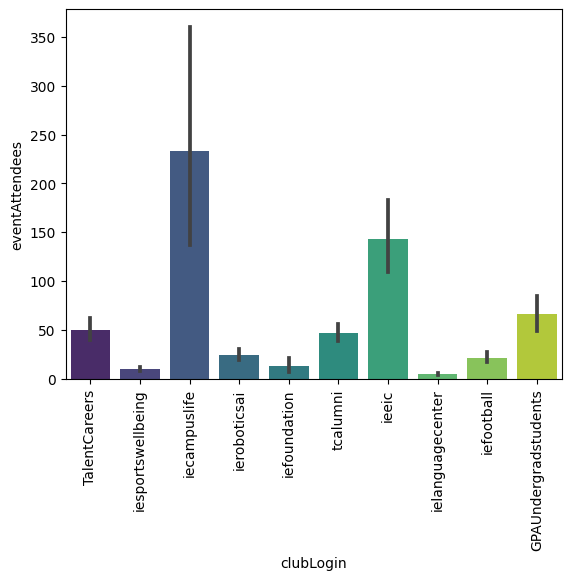

In [31]:
# clubLogin-eventAttendees only top 10 clubs
sns.barplot(x='clubLogin', y='eventAttendees', data=td, order=td['clubLogin'].value_counts().iloc[:10].index, palette='viridis')
# rotate x labels
plt.xticks(rotation=90)


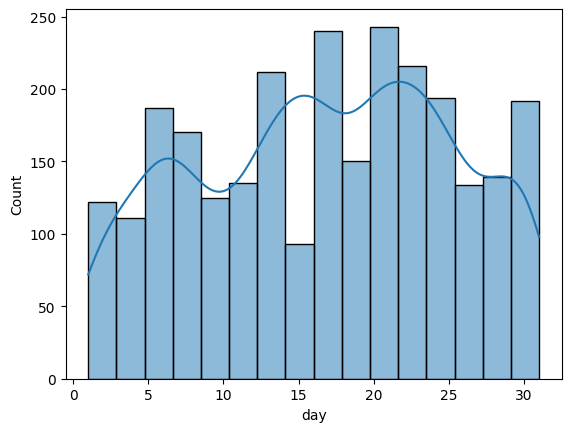

In [32]:
# hist day-eventAttendees
sns.histplot(td['day'], kde=True)
plt.show()

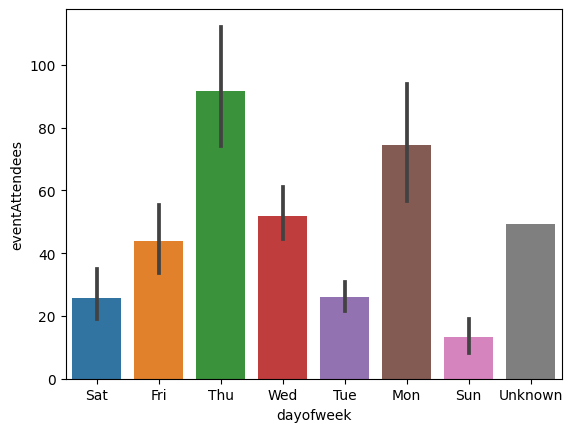

In [33]:
# dist eventAttendees
sns.barplot(x='dayofweek', y='eventAttendees', data=td)
plt.show()

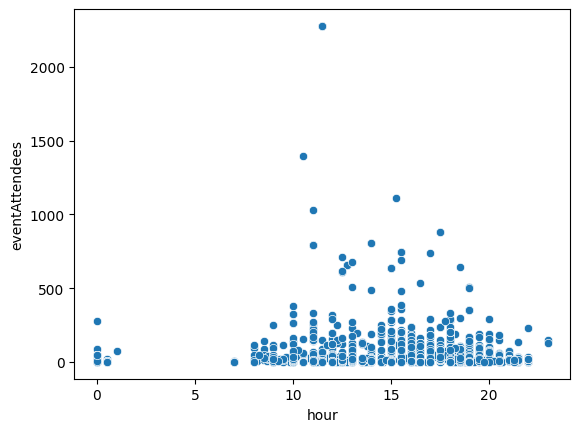

In [34]:
# hour-eventAttendees
sns.scatterplot(x='hour', y='eventAttendees', data=td)
plt.show()

<AxesSubplot: >

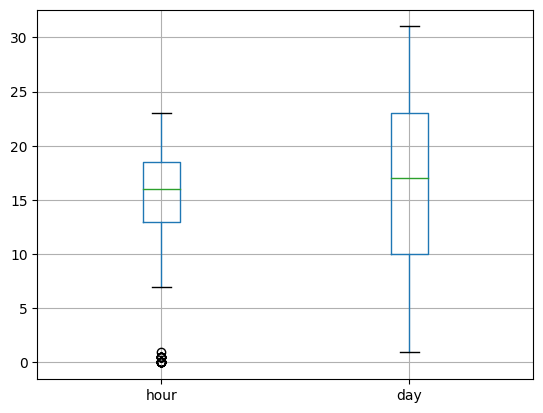

In [35]:
td[['hour', 'day']].boxplot()

In [36]:
# best hour to host an event
# to 10
td.groupby('hour')['eventAttendees'].mean().sort_values(ascending=False).head(20)

hour
15.25    612.500000
11.50    438.227273
12.75    379.142857
13.25    196.000000
11.00    158.194444
23.00    140.000000
15.50    124.621053
12.50    114.476190
17.75    110.250000
12.25     88.250000
14.50     85.916667
17.50     81.781250
1.00      74.000000
11.75     69.000000
10.00     68.157895
10.50     65.500000
10.25     61.500000
14.00     60.456140
18.00     59.839506
8.50      55.500000
Name: eventAttendees, dtype: float64

In [37]:
# best day to host an event
td.groupby('dayofweek')['eventAttendees'].mean().sort_values(ascending=False)

dayofweek
Thu        91.718861
Mon        74.337302
Wed        51.943627
Unknown    49.334212
Fri        43.847619
Tue        25.924089
Sat        25.619403
Sun        13.155340
Name: eventAttendees, dtype: float64

In [38]:
# best day of the month to host an event
td.groupby('day')['eventAttendees'].mean().sort_values(ascending=False)

day
25.000000    132.202532
21.000000    109.661290
26.000000    102.392857
23.000000     68.644628
2.000000      68.222222
24.000000     60.260870
22.000000     59.494737
4.000000      56.578947
31.000000     56.129032
15.000000     54.655914
16.722619     49.334212
8.000000      47.900000
10.000000     47.256757
14.000000     45.706897
20.000000     44.260504
7.000000      43.420000
1.000000      41.847458
27.000000     41.760000
3.000000      41.397260
11.000000     40.510638
28.000000     39.067568
6.000000      38.719101
19.000000     37.541667
29.000000     32.569231
18.000000     29.185185
13.000000     29.145833
30.000000     27.561538
12.000000     26.181818
5.000000      25.591837
17.000000     24.592593
16.000000     24.349206
9.000000      14.588235
Name: eventAttendees, dtype: float64

In [87]:
# explore checkin var
td['checkin'].value_counts()

0.44    2423
0.00     135
1.00     105
Name: checkin, dtype: int64

<AxesSubplot: >

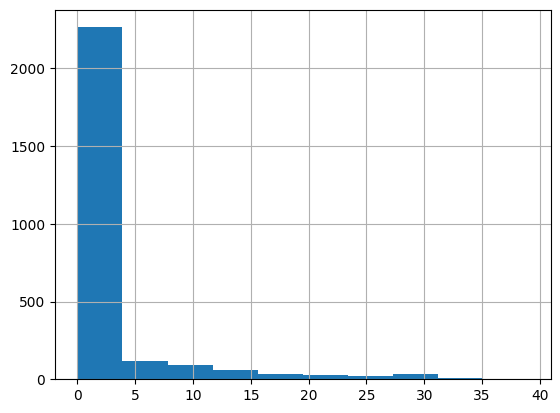

In [97]:
# explore registrationStatus
td['registrationStatus'].value_counts()
# create a success score based on the registrationStatus and attendance
# turn into howmany spots were unoccupied based on the registrationStatus values
# extract numbers from registrationStatus
# if no number, return 0
tdc['registrationStatus'].hist()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Online Event Zoom link'),
  Text(1, 0, 'Online Event'),
  Text(2, 0, 'Private Location (register to display)'),
  Text(3, 0, 'CAMPUS SEGOVIA'),
  Text(4, 0, 'TBD')])

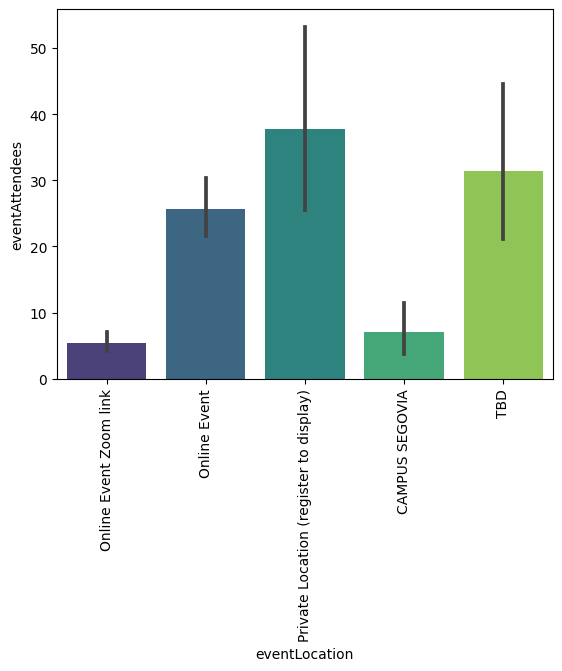

In [39]:
# barfor location-eventAttendees
sns.barplot(x='eventLocation', y='eventAttendees', data=td, order=td['eventLocation'].value_counts().iloc[:5].index, palette='viridis')
# rotate x labels
plt.xticks(rotation=90)

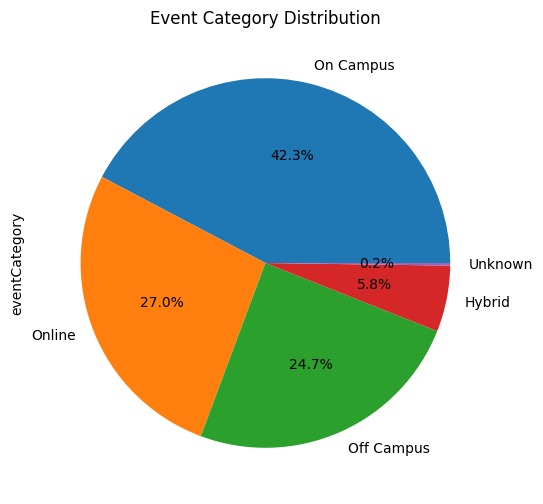

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Event Category Distribution
plt.figure(figsize=(10,6))
td['eventCategory'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Event Category Distribution')
plt.show()

([<matplotlib.axis.XTick at 0x7f0a3f897c10>,
 [Text(0.0, 0, '2/24/2024'),
  Text(10.0, 0, '2/14/2024'),
  Text(20.0, 0, '2/3/2024'),
  Text(30.0, 0, '1/24/2024'),
  Text(40.0, 0, '1/14/2024'),
  Text(50.0, 0, '12/20/2023'),
  Text(60.0, 0, '12/10/2023'),
  Text(70.0, 0, '11/30/2023'),
  Text(80.0, 0, '11/20/2023'),
  Text(90.0, 0, '11/10/2023'),
  Text(100.0, 0, '10/31/2023'),
  Text(110.0, 0, '10/21/2023'),
  Text(120.0, 0, '10/11/2023'),
  Text(130.0, 0, '10/1/2023'),
  Text(140.0, 0, '9/21/2023'),
  Text(150.0, 0, '9/11/2023'),
  Text(160.0, 0, '8/31/2023'),
  Text(170.0, 0, '7/19/2023'),
  Text(180.0, 0, '7/5/2023'),
  Text(190.0, 0, '6/22/2023'),
  Text(200.0, 0, '6/7/2023'),
  Text(210.0, 0, '5/27/2023')])

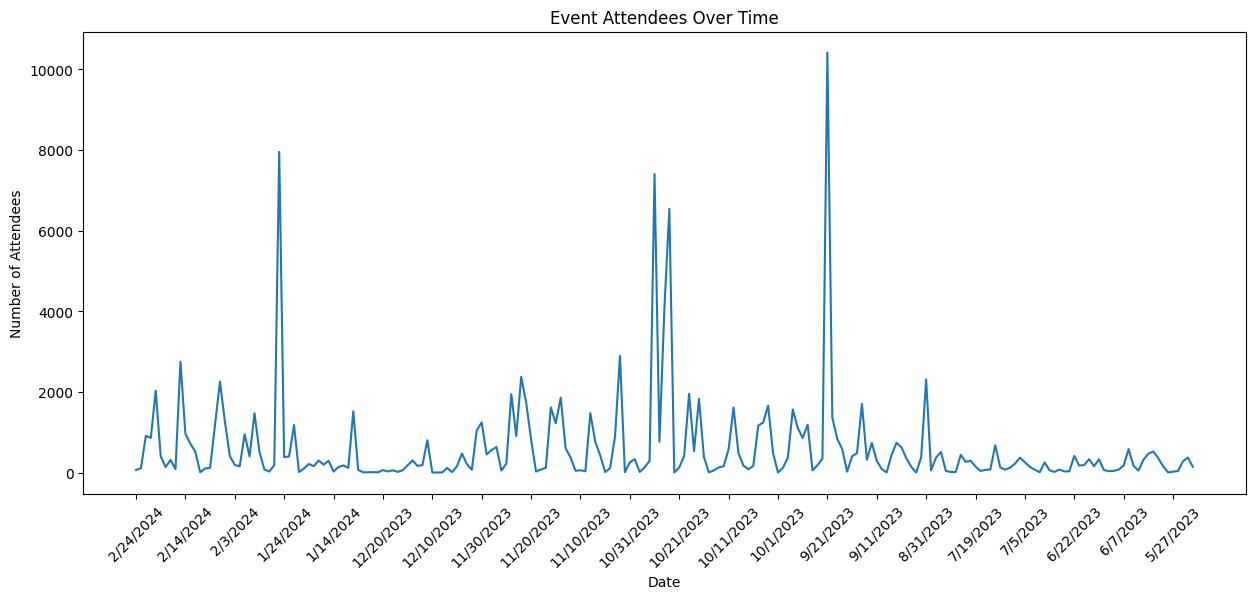

In [41]:
# Event Attendees Over Time
# combine day, month, year to create a date column
month_dict = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
from datetime import datetime
dt = {}
for row in td.iterrows():
    try:
        date_str = f"{month_dict[row[1]['month'].lower()]}/{int(row[1]['day'])}/{int(row[1]['year'])}"
        date_obj = datetime.strptime(date_str, '%m/%d/%Y')
        if date_str in dt:
            dt[date_str] += row[1]['eventAttendees']
        else:
            dt[date_str] = row[1]['eventAttendees']
    except:
        row[1]['date'] = np.nan
# plot the number of attendees over time
plt.figure(figsize=(15,6))
plt.plot(dt.keys(), dt.values())
plt.title('Event Attendees Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Attendees')
# every 10th date 
plt.xticks(list(dt.keys())[::10], rotation=45)

<AxesSubplot: xlabel='eventAttendees', ylabel='Density'>

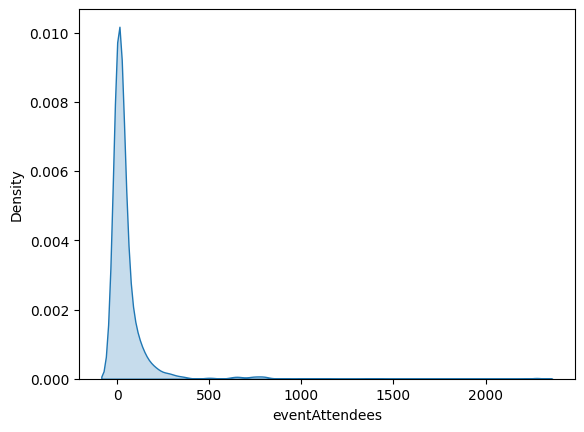

In [42]:
# kernel density estimate of eventAttendees
sns.kdeplot(td['eventAttendees'], fill=True)

In [56]:
# create a regression model to predict eventAttendees base on event name
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

,eventId,eventUid,eventName,eventCategory,eventLocation,clubId,clubLogin,clubName,eventAttendees,eventPriceRange,...,hybrid,dayofweek,month,day,year,time,eventDates,hour,spots_left,success


In [135]:
# create a tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
# decide on max_features based on the number of unique words in the event names
max_features = 0
unique_words = set()
for i in td['eventName']:
    unique_words.update(i.split())
max_features = len(unique_words)
print(max_features)
tdu = td.copy()
tdu.fillna(0, inplace=True)
y = tdu['success']
vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
# turn X into a DataFrame
X = vectorizer.fit_transform(tdu['eventName'])
X = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

3591


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
!pip install lazypredict

Defaulting to user installation because normal site-packages is not writeable


In [137]:
# create a linear regression model
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
dofit = False
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

  2%|▏         | 1/42 [00:04<03:06,  4.56s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.06477592239694974, 'Adjusted R-Squared': 1.2416411895506667, 'RMSE': 0.24731689471641366, 'Time taken': 4.557120084762573}


  5%|▍         | 2/42 [00:15<05:37,  8.44s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.13851959640013778, 'Adjusted R-Squared': 1.2225874573652873, 'RMSE': 0.23736607398958767, 'Time taken': 11.164016723632812}


  5%|▍         | 2/42 [01:08<22:51, 34.28s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_312716/1863239795.py", line 5, in <module>
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/velocitatem/.local/lib/python3.11/site-packages/lazypredict/Supervised.py", line 603, in fit
    pipe.fit(X_train, y_train)
  File "/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py", line 273, in fit
    U, S, Vh = linalg.svd(X, full_matrices=False)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/site-packages/scipy/linalg/_decomp_svd.py", line 127, in svd
    u, 

In [125]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,


In [80]:
# hyperparameter tuning for the best model: OrthogonalMatchingPursuitCV


/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requ

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_312716/896403882.py", line 12, in <module>
    grid_search.fit(X_train, y_train)
  File "/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
    out = parallel(
          ^^^^^^^^^
  File "/home/velocitatem/.local/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^

In [138]:
# top mode;: xgboost
from xgboost import XGBRegressor
Amodel = XGBRegressor(verbose=True)
Amodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# quick grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 300,  500],
    'learning_rate': [0.01, 0.3],
    'max_depth': [3,  5,  7]
}
grid_search = GridSearchCV(Amodel, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [139]:
# make predictions
y_pred = Amodel.predict(X_test)
# evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.056373115514129435
R2 Score: 0.13805382513177644


In [76]:
# create a function to predict the number of attendees for a given event name
def predict_attendees(event_name):
    # vectorize the event name
    event_name = event_name.lower()
    event_name_vectorized = vectorizer.transform([event_name])
    event_name_vectorized = pd.DataFrame(event_name_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
    print(event_name_vectorized)
    pr = Amodel.predict(event_name_vectorized)
    mse = mean_squared_error(y_test, y_pred)
    return pr 

predict_attendees('AI Pitch Week: IE Startup Sprint')

    10  105m  108  10th   11   12   13   14   15  15b  ...  years  yoga  \
0 0.00  0.00 0.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00  ...   0.00  0.00   

   young  youth  yuri  zanón  zarzuela  zoido  ángel  étranger  
0   0.00   0.00  0.00   0.00      0.00   0.00   0.00      0.00  

[1 rows x 1000 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(array([67.2]), 5957.169496734844)

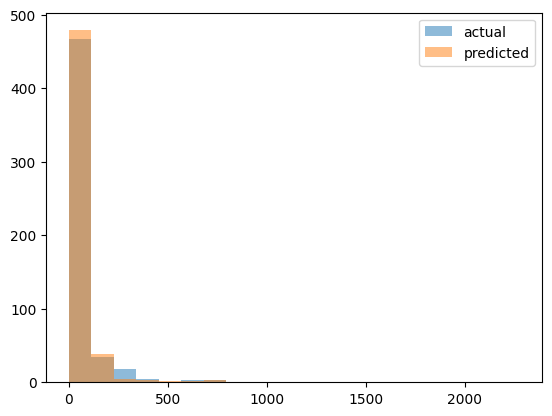

In [70]:
# hist test, pred
plt.hist(y_test, bins=20, alpha=0.5, label='actual')
plt.hist(y_pred, bins=20, alpha=0.5, label='predicted')
plt.legend()
plt.show()